In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
RSEED = 45

In [20]:
Data=pd.read_csv('data_new.csv')
Data.head()

,Title,Year,Score,Genre,Vote,Director,Runtime,Revenue,Oscar,Guild,Globe,win,nominee
0,'71,2014,7.2,"Action, Drama, Thriller",44532,Yann Demange,99,1.27,-1.0,-1.0,-1.0,-1.0,False
1,'A' gai wak,1983,7.4,"Action, Comedy",12657,Jackie Chan,105,NaN,-1.0,-1.0,-1.0,-1.0,False
2,'A' gai wak 2,1987,7.2,"Action, Comedy, Crime",7739,Jackie Chan,101,NaN,-1.0,-1.0,-1.0,-1.0,False
3,'I Know Where I'm Going!',1945,7.6,"Drama, Romance",6861,Michael Powell,91,NaN,-1.0,-1.0,-1.0,-1.0,False
4,(T)Raumschiff Surprise - Periode 1,2004,5.4,"Comedy, Sci-Fi",12158,Michael Herbig,87,NaN,-1.0,-1.0,-1.0,-1.0,False


In [21]:
df = Data
df = df.drop(['Title',  'Genre', 'Director', 'Year','Revenue','Oscar','Guild','Globe','win'],axis = 1)

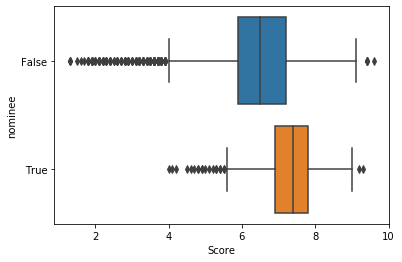

In [5]:
# уберем значения и фильмы, которые точно не будут номинированы 
sns.boxplot(y="nominee", x="Score", data=df, orient="h")

In [22]:
df = df.drop(df[df.Score < 4].index)

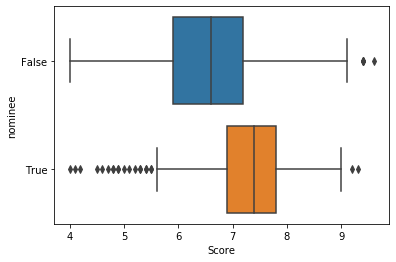

In [7]:
sns.boxplot(y="nominee", x="Score", data=df, orient="h")

In [23]:
labels = np.array(df.pop('nominee'))

train, test, train_labels, test_labels = train_test_split(df,
                                         labels, 
                                         stratify = labels,
                                         test_size = 0.3, 
                                         random_state = RSEED)

In [24]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)
train.shape

(6881, 3)

In [25]:
test.shape

(2950, 3)

In [28]:
# Create the model with 1000 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)
win_pred=model.predict(test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [30]:
print("Accuracy:",metrics.accuracy_score(test_labels, win_pred))

Accuracy: 0.8223728813559322


In [12]:
model.score(test, test_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.8223728813559322

In [13]:
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 2399
Average maximum depth 25


Confusion matrix, without normalization
[[2242  164]
 [ 360  184]]


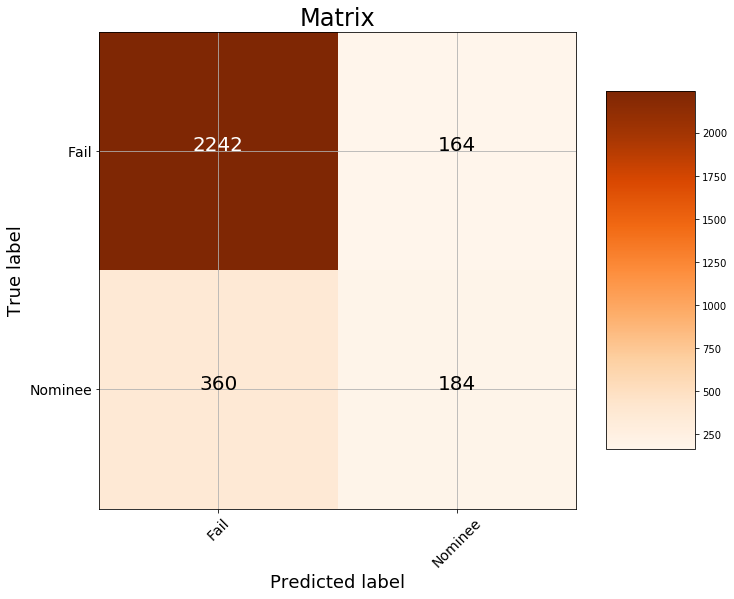

In [32]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(test_labels, win_pred)
plot_confusion_matrix(cm, classes = ['Fail', 'Nominee'],
                      title = 'Matrix')


In [38]:
#для построения кривой обучения
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

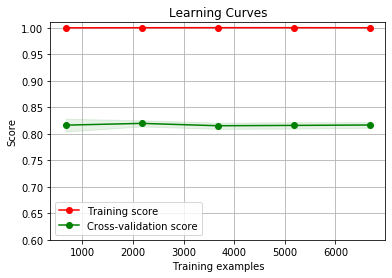

In [41]:
title = "Learning Curves"
cv = ShuffleSplit(n_splits=5, test_size=0.32, random_state=0)
estimator = model
plot_learning_curve(estimator, title, df, labels, (0.6, 1.01), cv=cv, n_jobs=4)
plt.show()